In [2]:
import sys
import wandb
import hydra
from omegaconf import OmegaConf

sys.path.append('../')
from model.unet import get_unet
from model.dae import get_daes

In [3]:
cfg = OmegaConf.load('../configs/basic_config.yaml')

In [23]:
data_key = 'brain'
OmegaConf.update(cfg, 'run.data_key', data_key)
OmegaConf.update(cfg, 'run.iteration', 0)

# default unet
cfg.unet[data_key].arch = 'default'
default_unet = get_unet(cfg, return_state_dict=False)

# monai unet
cfg.unet[data_key].arch = 'monai'
cfg.unet[data_key].depth = 4
cfg.unet[data_key].n_filters_init = 16
cfg.unet[data_key].num_res_units = 4
monai_unet, swivels = get_unet(cfg, return_state_dict=False, return_swivels=True)
cfg.dae = OmegaConf.load('../configs/dae/resDAE_config.yaml')
cfg.dae.arch = OmegaConf.merge(cfg.dae.arch, swivels)

cfg.dae.identity_swivels = [0,1,2]
cfg.dae.trainer.disabled_ids = [list(cfg.dae.arch.keys())[i] for i in cfg.dae.identity_swivels]

# swinunetr
cfg.unet[data_key].arch = 'swinunetr'
swinunetr = get_unet(cfg, return_state_dict=False)



In [24]:
print(OmegaConf.to_yaml(cfg))

debug: false
wandb:
  log: true
  project: MICCAI2023-extension
fs:
  root: ../../
data:
  brain:
    data_path: data/conp-dataset/projects/calgary-campinas/CC359/Reconstructed/
  heart:
    data_path: data/mnm/
unet:
  brain:
    pre: calgary_unet
    n_chans_in: 1
    n_filters_init: 16
    n_chans_out: 1
    training:
      save_loc: pre-trained
      train_site: 6
      augment: true
      validation: true
      batch_size: 32
      num_batches_per_epoch: 250
      epochs: 250
      patience: 4
      lr: 0.001
    arch: swinunetr
    depth: 4
    num_res_units: 4
  heart:
    pre: acdc_unet
    n_chans_in: 1
    n_filters_init: 8
    n_chans_out: 4
    training:
      save_loc: pre-trained
      augment: true
      validation: true
      batch_size: 32
      num_batches_per_epoch: 250
      num_val_batches_per_epoch: 50
      epochs: 250
      patience: 4
      lr: 0.001
run:
  data_key: brain
  iteration: 0
dae:
  model: ResDAE
  name: None
  arch:
    depth: 20
    model.1.swivel

In [17]:
swivels.keys

<function dict.keys>

In [4]:
for name, module in monai_unet.named_modules():
    
    if "swivel" in name.lower():
        print(name)

        tmp = monai_unet.get_submodule(name)

model.1.submodule.1.submodule.1.submodule.1.swivel
model.1.submodule.1.submodule.1.swivel
model.1.submodule.1.swivel
model.1.swivel


In [1]:
tmp

NameError: name 'tmp' is not defined

In [12]:
[f'model.1.{"submodule.1." * i}swivel' for i in range(4)]

['model.1.swivel',
 'model.1.submodule.1.swivel',
 'model.1.submodule.1.submodule.1.swivel',
 'model.1.submodule.1.submodule.1.submodule.1.swivel']

In [11]:

monai_unet.get_submodule('model.1.submodule.1.submodule.1.submodule.conv.unit3')

Convolution(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adn): ADN(
    (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (D): Dropout(p=0.0, inplace=False)
    (A): PReLU(num_parameters=1)
  )
)

In [32]:
import graphviz
graphviz.set_jupyter_format('png')

from torchview import draw_graph
import torch

In [48]:
model_graph = draw_graph(monai_unet, input_size=(1,1,256,256), device='cpu')

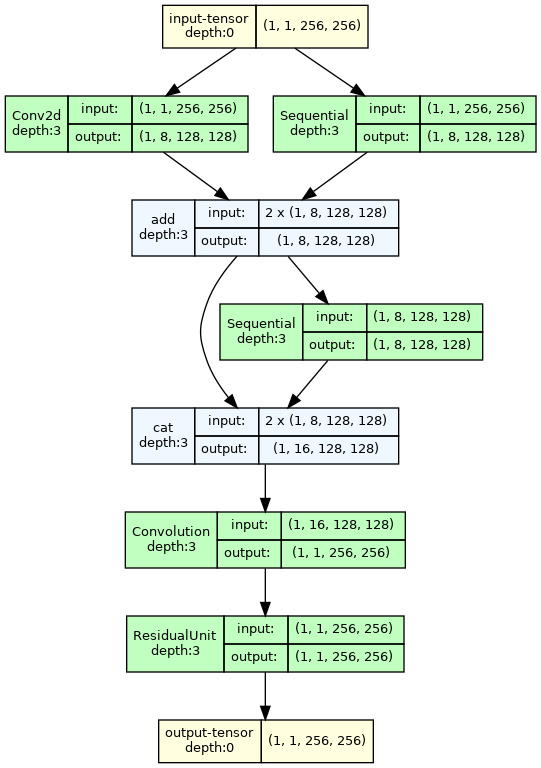

In [49]:
model_graph.visual_graph

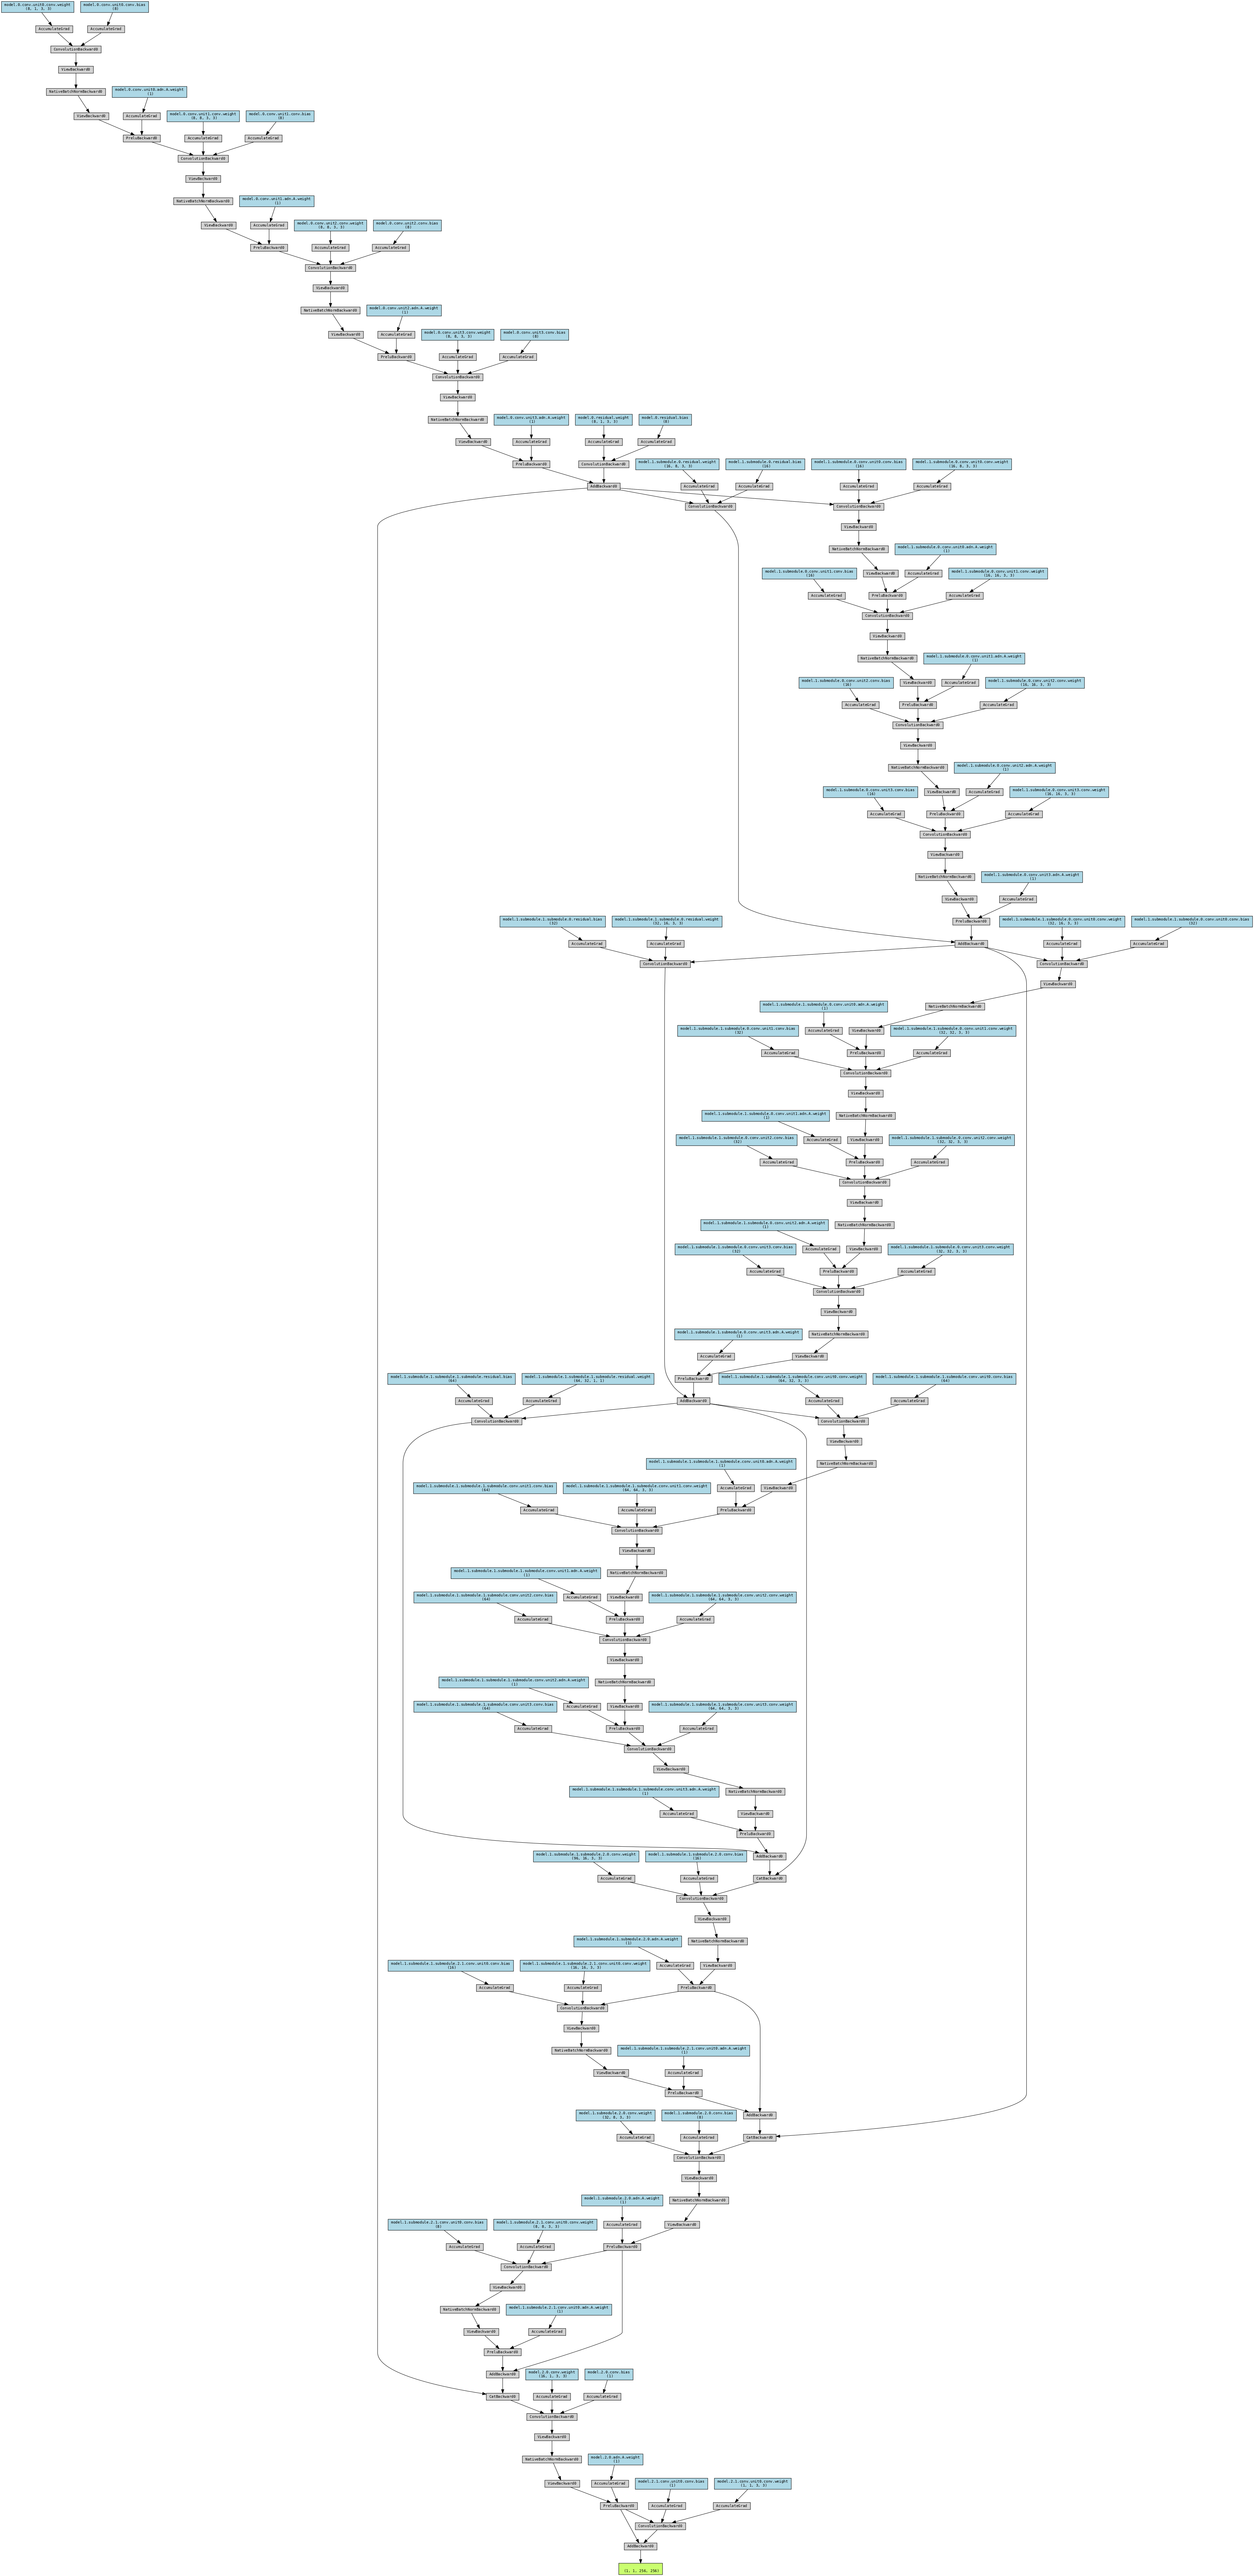

In [41]:
from torchviz import make_dot

x = torch.randn(1, 1, 256, 256)

y = monai_unet(x)
make_dot(y, params=dict(monai_unet.named_parameters()))